
## Семинар 4. Модели экспоненциального сглаживания. Порядок построения и валидации модели.



In [114]:
from sktime.datasets import load_uschange
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np


from sktime.forecasting.all import temporal_train_test_split
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

from sktime.datasets import load_macroeconomic, load_airline

from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

from sktime.utils.plotting import plot_correlations


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


### Модели Хольта-Винтерса и ETS

Для начала возьмём какие-нибудь простые данные без трендов. В нашем случае это будет один из стандартных датасетов. Используем процентные изменения в совокупном потреблении США c 1960 по 2006.

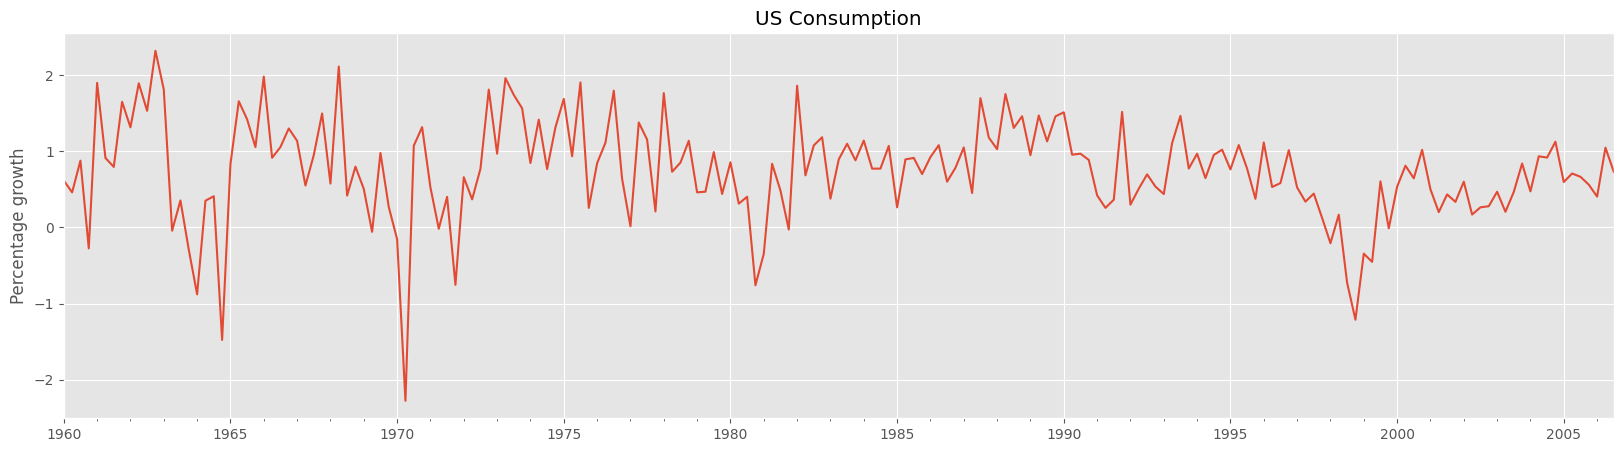

In [115]:
y, _ = load_uschange()
y.index = pd.date_range(start="1960.01.01", periods=len(y), freq="Q").to_period()

# Если потребуются мультипликативные модели, необходимо децентрировать данные
# y = y + 10


y_train, y_test = temporal_train_test_split(y, test_size=10)

y.plot()
plt.title("US Consumption")
plt.ylabel("Percentage growth");

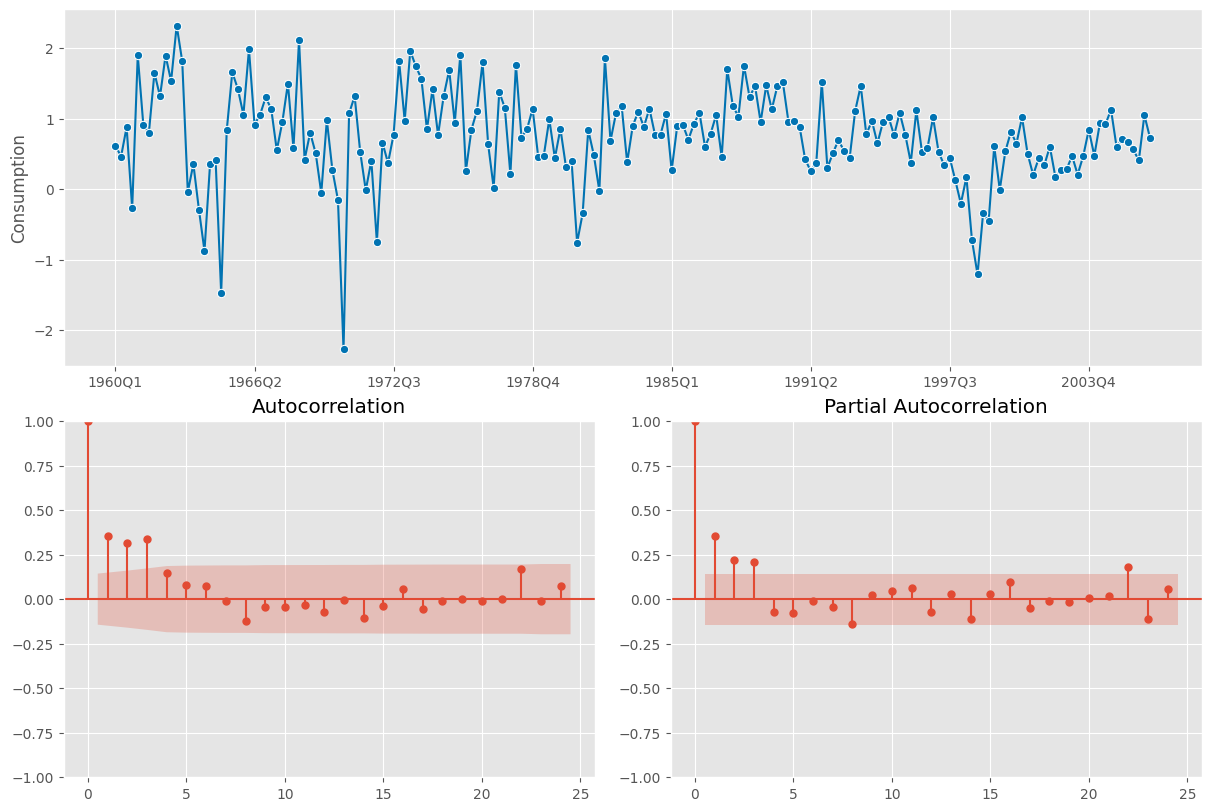

In [116]:
plot_correlations(y);

Импортируем модели Хольта-Винтерса и ETS. Из последнего семинара мы знаем, что эти модели в целом различаются только метедом оценки, но структурно эквивалентны. Посмотрим на простом примере, а далее будем использовать только ETS, чтобы не дублировать слишком много кода.

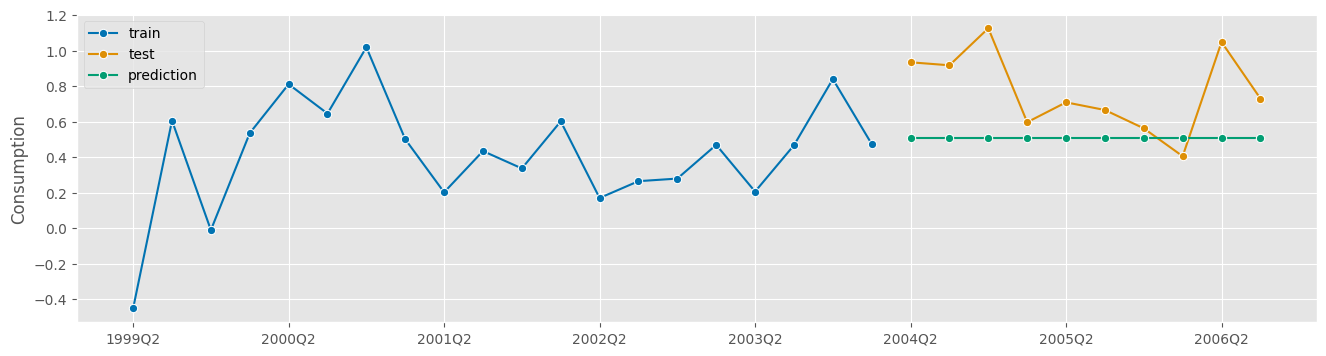

In [117]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,11)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);



In [119]:
mean_absolute_percentage_error(y_test, y_pred)

0.3316275942998241

In [120]:
forecaster._fitted_forecaster.params

{'smoothing_level': 0.3278115802315111,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.6911219323084307,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

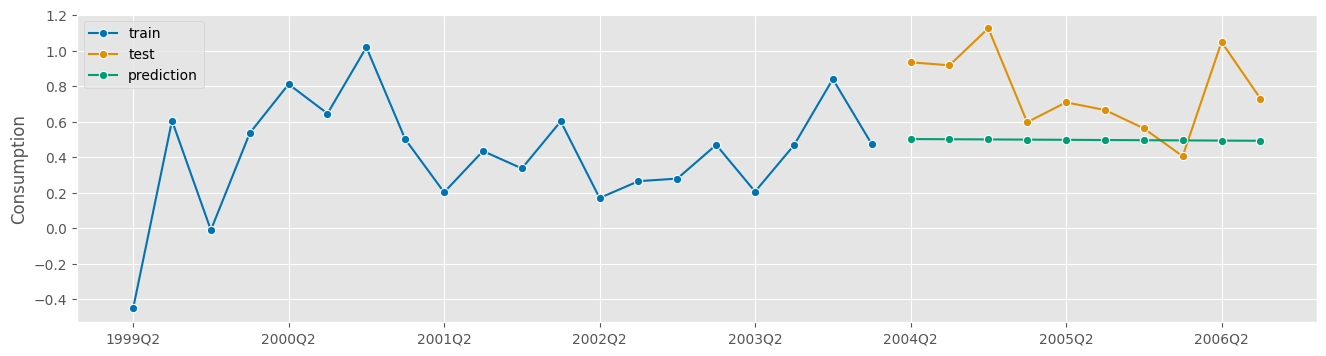

In [121]:
forecaster = ExponentialSmoothing(trend="add")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,11)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);


In [122]:
mean_absolute_percentage_error(y_test, y_pred)

0.3385066680115455

In [123]:
forecaster._fitted_forecaster.params

{'smoothing_level': 0.32758913360166575,
 'smoothing_trend': 4.0501381775665075e-11,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.6944728386196037,
 'initial_trend': -0.0010868289836101805,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Как видим ниже, оценён параметр $l_0$. Вообще параметр $\alpha$ тоже под капотом оценился, но почему-то не пробросился.

Внимательный читатель спросит, мол, как это оценены информационные критерии, у нас же эти модели оцениваются не через правдоподобие. В таком случае можно записать информационные критерии через MSE, а не через правдоподобие. Более того, вариантов записи информационных критериев существует немало, поэтому рекомендуется всегда поглядывать в документацию или потроха пакета.

In [7]:
forecaster.get_fitted_params()

{'initial_level': 0.6911213997099445,
 'initial_slope': None,
 'initial_seasons': array([], dtype=float64),
 'aic': -158.5427607316124,
 'bic': -152.19046126646472,
 'aicc': -158.3102025920775}

In [10]:
forecaster._fitted_forecaster.aic()

-158.54276073082403

In [20]:
forecaster.predict_interval()

NotImplementedError: ExponentialSmoothing does not have the capability to return prediction intervals. If you think this estimator should have the capability, please open an issue on sktime.

Теперь оценим ETS(A,N,N)-модель. Как видим, легко получается то же самое.

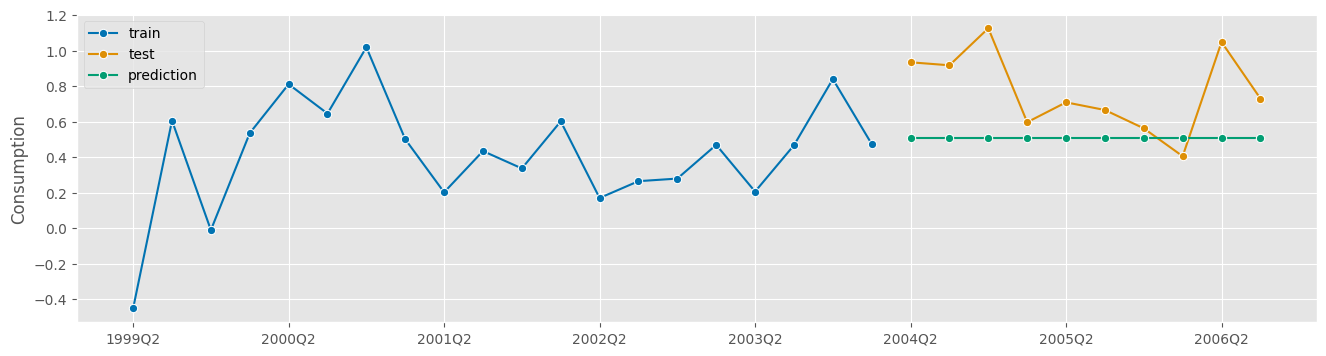

In [124]:
forecaster = AutoETS()
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,11)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')


Однако выдача ETS-модели куда приятнее. Видим, что оценки $l_o$ и $\alpha$ совпали с предыдущим случаем.

In [125]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  177
Model:                       ETS(ANN)   Log Likelihood                -169.881
Date:                Mon, 13 Feb 2023   AIC                            345.761
Time:                        20:28:13   BIC                            355.290
Sample:                    03-31-1960   HQIC                           349.626
                         - 03-31-2004   Scale                            0.399
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.3278      0.069      4.752      0.000       0.193       0.463
initial_level       0.6910      0.471      1.468      0.142      -0.232       1.614
===================================================================================
Ljung-Box (Q):                        0.05   Jarque-Bera (JB):                22.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

Теперь возьмём какие-нибудь трендированные данные.

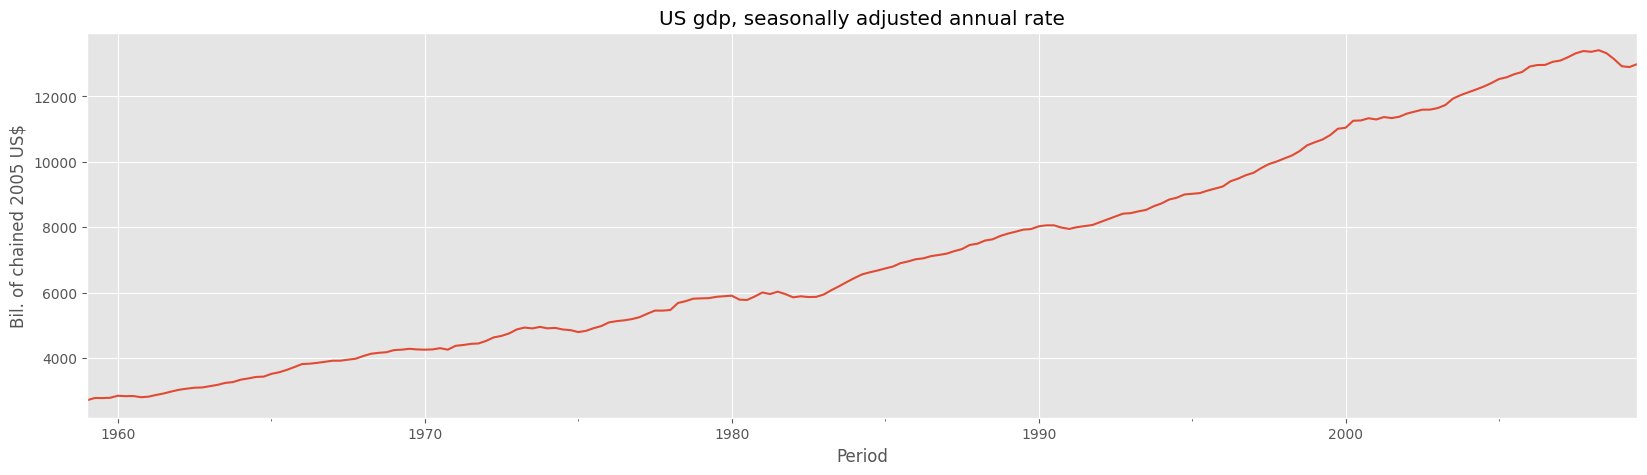

In [126]:
y = load_macroeconomic().realgdp
y.plot()
plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

y_train, y_test = temporal_train_test_split(y, test_size=35)

Text(0, 0.5, 'Bil. of chained 2005 US$')

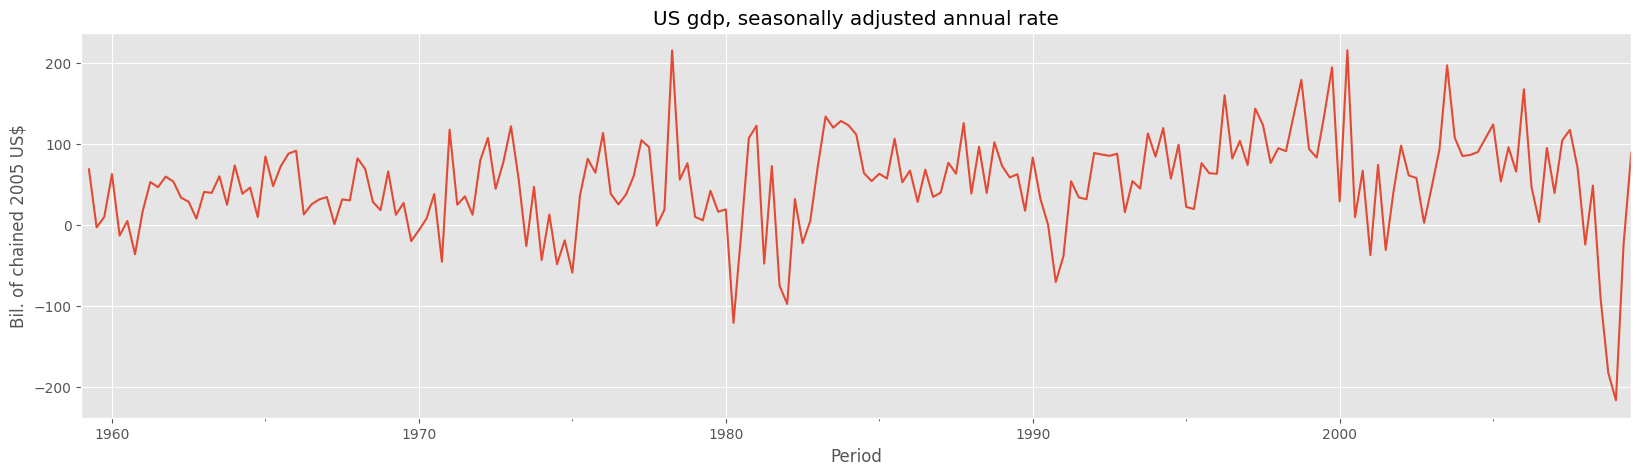

In [127]:
y.diff().plot()
plt.title('US gdp, seasonally adjusted annual rate')
plt.ylabel('Bil. of chained 2005 US$')

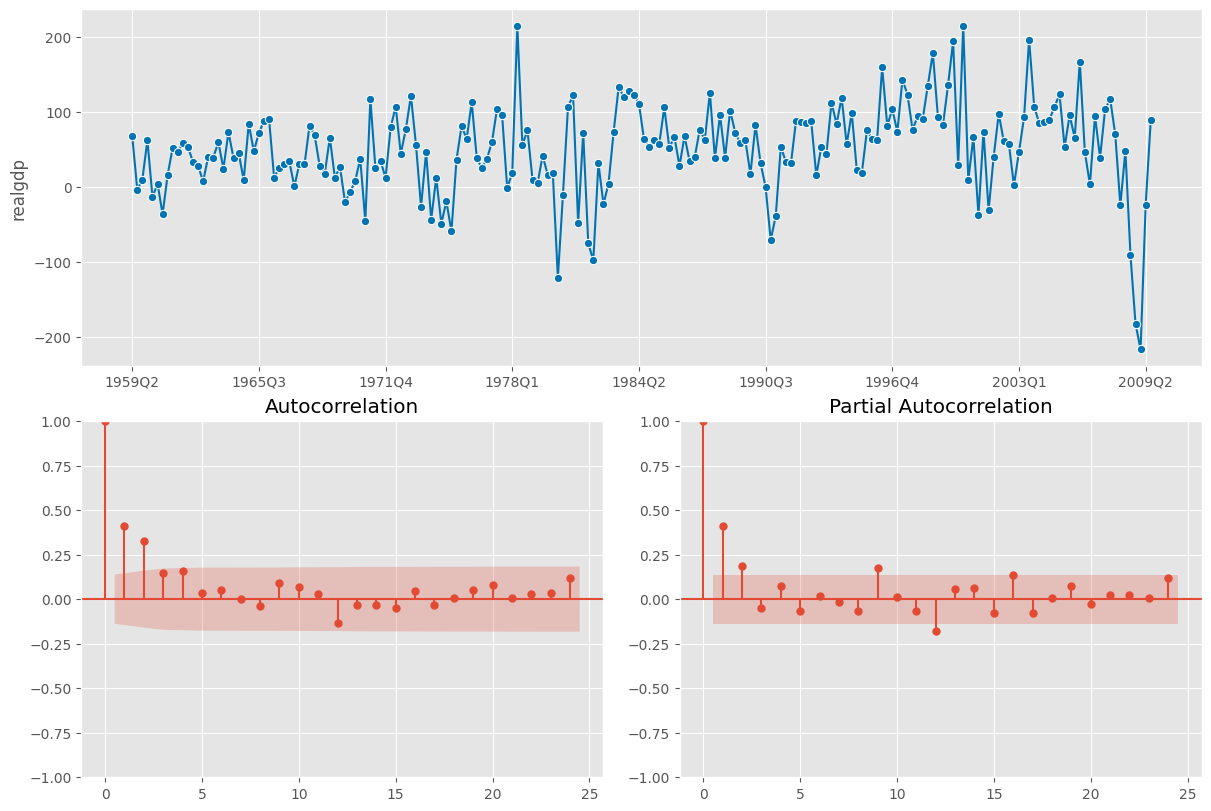

In [128]:
plot_correlations(y.diff().dropna());

Понятное дело, что здесь уже необходимо применять модель, в которой есть трендовая компонента. Попробуем применить.

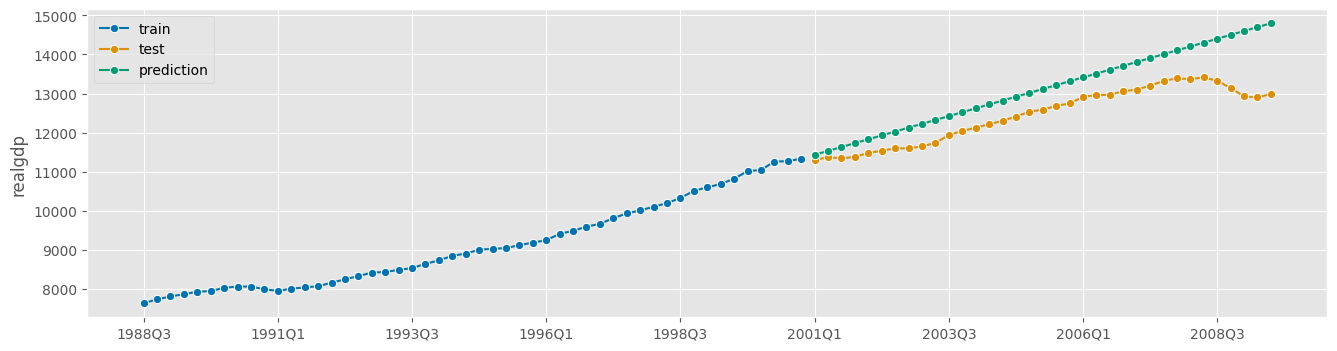

In [129]:
forecaster = AutoETS(trend="add")
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(50), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()

In [130]:
mean_absolute_percentage_error(y_test, y_pred)

0.05303744171163129

Видим явную переоценку тренда. Попробуем дампировать

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  168
Model:                      ETS(AAdN)   Log Likelihood                -896.982
Date:                Mon, 13 Feb 2023   AIC                           1805.964
Time:                        20:28:53   BIC                           1824.708
Sample:                    03-31-1959   HQIC                          1813.571
                         - 12-31-2000   Scale                         2541.424
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.284      3.527      0.000       0.444       1.556
smoothing_trend     0.2511      0.431      0.583      0.560      -0.594       1.096
damping_trend       0.9800      0.101      9.671      0.000       0.781       1.179
initial_level    2739.0843     53.151     51.534      0.000    2634.910    2843.259
initial_trend      12.2548     40.696      0.301      0.763     -67.507      92.017
===================================================================================
Ljung-Box (Q):                        0.90   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.64   Prob(JB):                         0.15
Heteroskedasticity (H):               1.89   Skew:                             0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

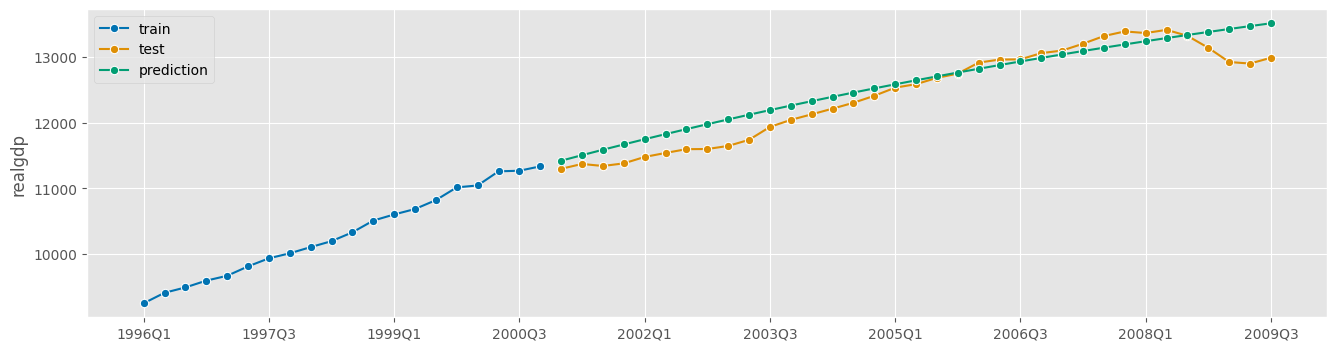

In [131]:
forecaster = AutoETS(trend="add", damped_trend=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()

In [132]:
mean_absolute_percentage_error(y_test, y_pred)

0.016382693691639395

Мультипликативный тренд, по понятным причинам, ничего особо не изменит, так как тренд затухающий, а не экспоненциальный. Да и дамприование с мультипликативным трендом выглядит несколько противоестественно.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                realgdp   No. Observations:                  168
Model:                      ETS(AMdN)   Log Likelihood                -897.171
Date:                Mon, 13 Feb 2023   AIC                           1806.341
Time:                        20:29:02   BIC                           1825.085
Sample:                    03-31-1959   HQIC                          1813.948
                         - 12-31-2000   Scale                         2547.136
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.174      5.762      0.000       0.660       1.340
smoothing_trend     0.2507      0.253      0.992      0.321      -0.244       0.746
damping_trend       0.9697      0.060     16.185      0.000       0.852       1.087
initial_level    2739.0854     53.354     51.338      0.000    2634.514    2843.656
initial_trend       1.0048      0.015     68.813      0.000       0.976       1.033
===================================================================================
Ljung-Box (Q):                        0.86   Jarque-Bera (JB):                 3.71
Prob(Q):                              0.65   Prob(JB):                         0.16
Heteroskedasticity (H):               1.89   Skew:                             0.05
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

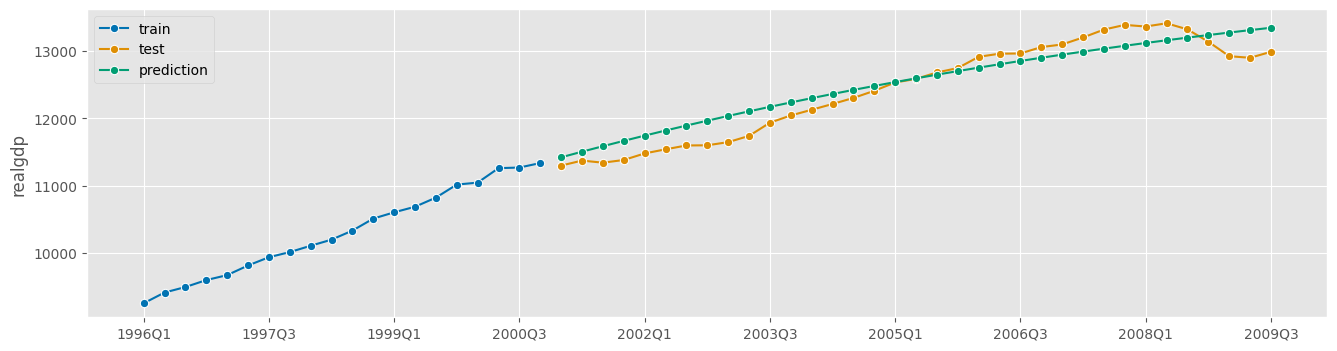

In [133]:
forecaster = AutoETS(trend="mul", damped_trend=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(20), y_test, y_pred,  labels=['train', 'test', 'prediction']);
forecaster.summary()



In [134]:
mean_absolute_percentage_error(y_test, y_pred)

0.01660804975211629

Теперь рассмотрим данные с трендом и сезонностью. Возьмём самый стандартный и избитый (но всё ещё прекрасный) пример с авиаперевозками с 1949 по 1960.

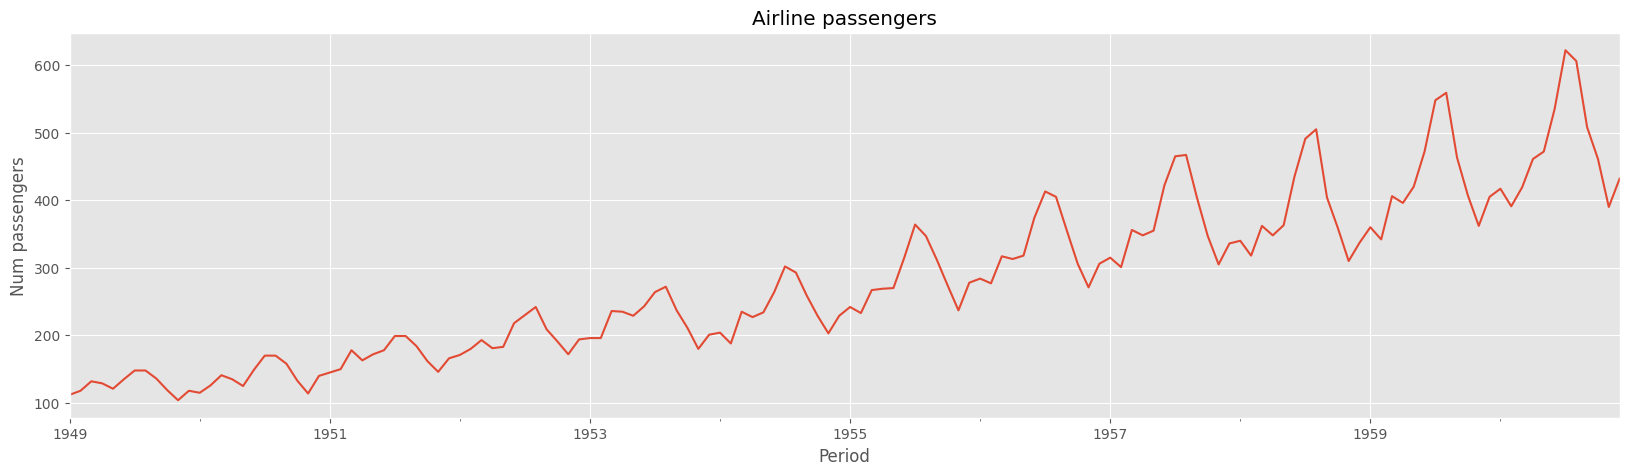

In [135]:
y = load_airline()
y.plot()
plt.title('Airline passengers')
plt.ylabel('Num passengers')

y_train, y_test = temporal_train_test_split(y, test_size=0.2)

Здесь у нас уже очевидно имеется сезонность. И более того, восходящий, схожий с экспоненциальным, тренд. Можно попробовать также использовать мультипликативную сезонность и мультипликативную ошибку, так как с ростом тренда растут колебания сезонности и, скорее всего, случайные шоки. Но сначала для сравнения возьмём аддитивную.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(AAA)   Log Likelihood                -441.531
Date:                          Mon, 13 Feb 2023   AIC                            919.062
Time:                                  20:29:13   BIC                            968.471
Sample:                              01-31-1949   HQIC                           939.117
                                   - 07-31-1958   Scale                          126.586
Covariance Type:                         approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2612      0.047      5.540      0.000       0.169       0.354
smoothing_trend      2.612e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.7388      0.073     10.169      0.000       0.596       0.881
initial_level         109.7342      5.968     18.388      0.000      98.038     121.431
initial_trend           2.2556      0.345      6.540      0.000       1.580       2.932
initial_seasonal.0     -2.5882      9.350     -0.277      0.782     -20.914      15.738
initial_seasonal.1    -19.2567      9.379     -2.053      0.040     -37.638      -0.875
initial_seasonal.2     -4.8065      9.303     -0.517      0.605     -23.040      13.427
initial_seasonal.3     14.0420      9.292      1.511      0.131      -4.170      32.254
initial_seasonal.4     28.2040      9.291      3.036      0.002       9.994      46.414
initial_seasonal.5     30.6418      9.289      3.299      0.001      12.437      48.847
initial_seasonal.6     18.3783      9.275      1.982      0.048       0.200      36.557
initial_seasonal.7      4.2212      9.275      0.455      0.649     -13.958      22.400
initial_seasonal.8     12.9257      9.277      1.393      0.164      -5.257      31.108
initial_seasonal.9     18.1941      9.310      1.954      0.051      -0.053      36.441
initial_seasonal.10     5.6772      9.289      0.611      0.541     -12.530      23.884
initial_seasonal.11          0      9.288          0      1.000     -18.205      18.205
===================================================================================
Ljung-Box (Q):                      140.71   Jarque-Bera (JB):                 5.11
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               6.14   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+16. Standard errors may be unstable.
"""

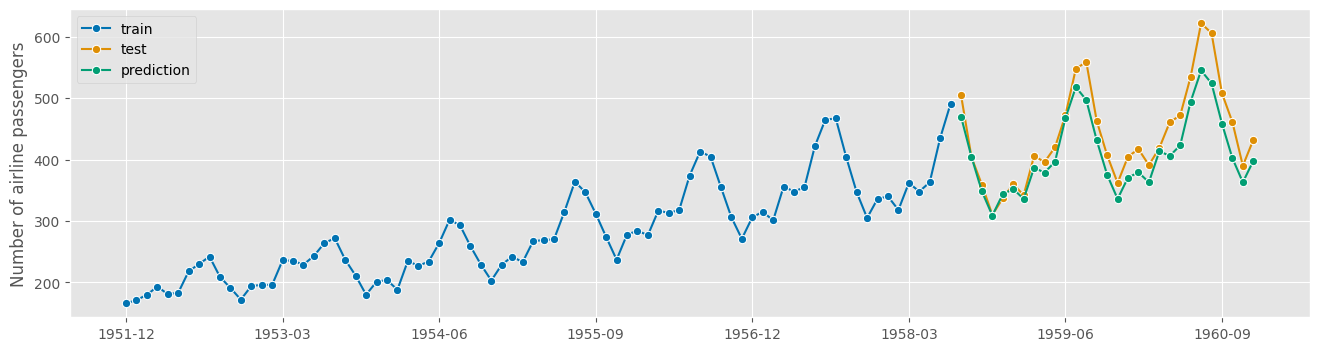

In [136]:
forecaster = AutoETS(error="add", trend="add", seasonal="add", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Добавим мультипликативный тренд

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(AMA)   Log Likelihood                -443.033
Date:                          Mon, 13 Feb 2023   AIC                            922.065
Time:                                  20:29:14   BIC                            971.474
Sample:                              01-31-1949   HQIC                           942.120
                                   - 07-31-1958   Scale                          129.935
Covariance Type:                         approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2670      0.044      6.096      0.000       0.181       0.353
smoothing_trend       2.67e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.7329      0.073     10.075      0.000       0.590       0.876
initial_level         107.9524     65.352      1.652      0.099     -20.134     236.039
initial_trend           1.0092        nan        nan        nan         nan         nan
initial_seasonal.0      3.1779     67.773      0.047      0.963    -129.654     136.010
initial_seasonal.1    -13.6690     67.516     -0.202      0.840    -145.998     118.660
initial_seasonal.2      0.5707     66.779      0.009      0.993    -130.314     131.456
initial_seasonal.3     19.2167     66.306      0.290      0.772    -110.741     149.174
initial_seasonal.4     33.1464     66.114      0.501      0.616     -96.434     162.727
initial_seasonal.5     35.2669     66.019      0.534      0.593     -94.129     164.663
initial_seasonal.6     22.6804     66.101      0.343      0.732    -106.875     152.236
initial_seasonal.7      8.2438     66.017      0.125      0.901    -121.148     137.635
initial_seasonal.8     16.7742     66.002      0.254      0.799    -112.587     146.135
initial_seasonal.9     21.8599     65.953      0.331      0.740    -107.407     151.126
initial_seasonal.10     9.1265     66.290      0.138      0.890    -120.800     139.053
initial_seasonal.11          0     66.508          0      1.000    -130.353     130.353
===================================================================================
Ljung-Box (Q):                      145.62   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               7.19   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

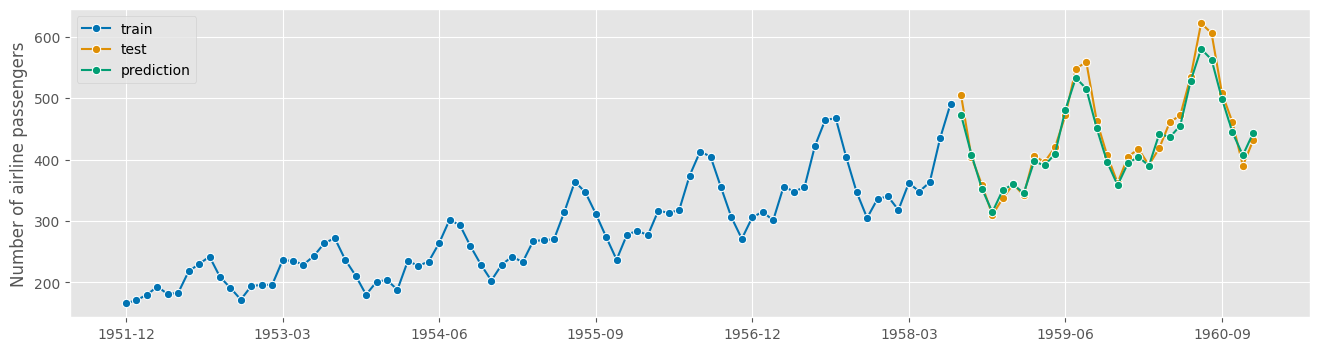

In [137]:
forecaster = AutoETS(error="add", trend="mul", seasonal="add", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Попробуем ещё мультипликативную сезонность. Видим, что верхние пики стали лучше угадываться, а нижние -- хуже. Качество упало.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(AMM)   Log Likelihood                -391.165
Date:                          Mon, 13 Feb 2023   AIC                            818.331
Time:                                  20:29:15   BIC                            867.740
Sample:                              01-31-1949   HQIC                           838.386
                                   - 07-31-1958   Scale                           52.720
Covariance Type:                         approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.087     11.511      0.000       0.830       1.170
smoothing_trend      9.999e-05      0.128      0.001      0.999      -0.251       0.251
smoothing_seasonal   2.963e-05        nan        nan        nan         nan         nan
initial_level         110.9447    346.210      0.320      0.749    -567.614     789.503
initial_trend           1.0093      0.025     40.389      0.000       0.960       1.058
initial_seasonal.0      0.9867      3.079      0.320      0.749      -5.048       7.021
initial_seasonal.1      0.8800      2.746      0.320      0.749      -4.502       6.262
initial_seasonal.2      1.0112      3.155      0.320      0.749      -5.173       7.196
initial_seasonal.3      1.1694      3.649      0.320      0.749      -5.983       8.322
initial_seasonal.4      1.3389      4.178      0.320      0.749      -6.850       9.528
initial_seasonal.5      1.3620      4.250      0.320      0.749      -6.968       9.692
initial_seasonal.6      1.2321      3.845      0.320      0.749      -6.304       8.768
initial_seasonal.7      1.0705      3.341      0.320      0.749      -5.477       7.618
initial_seasonal.8      1.0647      3.322      0.320      0.749      -5.447       7.576
initial_seasonal.9      1.1036      3.444      0.320      0.749      -5.646       7.853
initial_seasonal.10     0.9614      3.000      0.320      0.749      -4.919       6.841
initial_seasonal.11     1.0000      3.121      0.320      0.749      -5.116       7.116
===================================================================================
Ljung-Box (Q):                       35.91   Jarque-Bera (JB):                 3.67
Prob(Q):                              0.04   Prob(JB):                         0.16
Heteroskedasticity (H):               0.80   Skew:                            -0.34
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

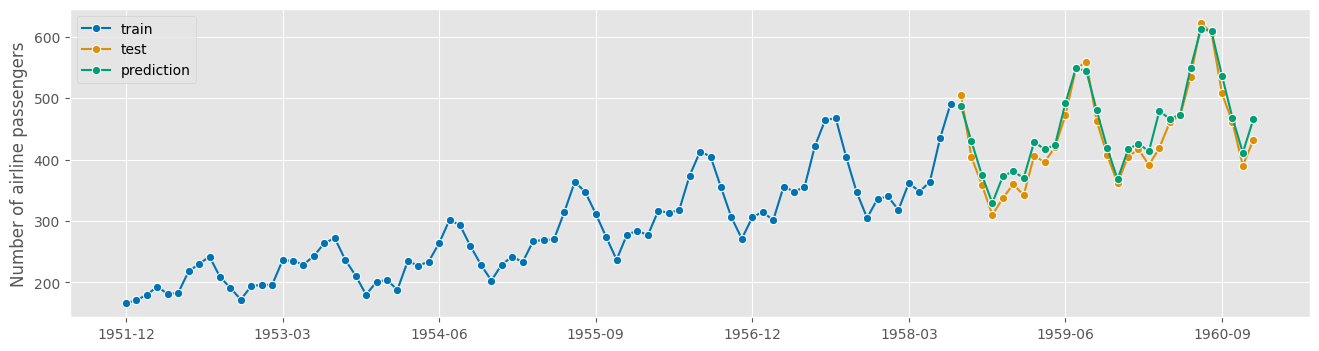

In [138]:
forecaster = AutoETS(error="add", trend="mul", seasonal="mul", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);


print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Если же сделать не сезонность мультипликативной, а ошибку, то особо ничего не изменится.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(MMA)   Log Likelihood                -427.390
Date:                          Mon, 13 Feb 2023   AIC                            890.781
Time:                                  20:29:18   BIC                            940.189
Sample:                              01-31-1949   HQIC                           910.835
                                   - 07-31-1958   Scale                            0.002
Covariance Type:                         approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2995      0.053      5.685      0.000       0.196       0.403
smoothing_trend      2.995e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.7005      0.079      8.874      0.000       0.546       0.855
initial_level         108.6080     54.477      1.994      0.046       1.835     215.381
initial_trend           1.0091      0.002    651.846      0.000       1.006       1.012
initial_seasonal.0      2.5326     55.838      0.045      0.964    -106.908     111.973
initial_seasonal.1    -14.6020     55.719     -0.262      0.793    -123.809      94.605
initial_seasonal.2      0.6743     55.178      0.012      0.990    -107.472     108.820
initial_seasonal.3     19.2403     54.752      0.351      0.725     -88.071     126.552
initial_seasonal.4     33.1905     54.597      0.608      0.543     -73.817     140.198
initial_seasonal.5     35.5068     54.644      0.650      0.516     -71.593     142.606
initial_seasonal.6     23.1796     55.015      0.421      0.674     -84.648     131.007
initial_seasonal.7      8.3936     55.143      0.152      0.879     -99.685     116.472
initial_seasonal.8     17.2566     54.991      0.314      0.754     -90.524     125.037
initial_seasonal.9     22.1395     54.855      0.404      0.687     -85.374     129.653
initial_seasonal.10     8.4974     55.114      0.154      0.877     -99.524     116.518
initial_seasonal.11          0     55.006          0      1.000    -107.810     107.810
===================================================================================
Ljung-Box (Q):                      101.55   Jarque-Bera (JB):                 4.40
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               1.32   Skew:                             0.39
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

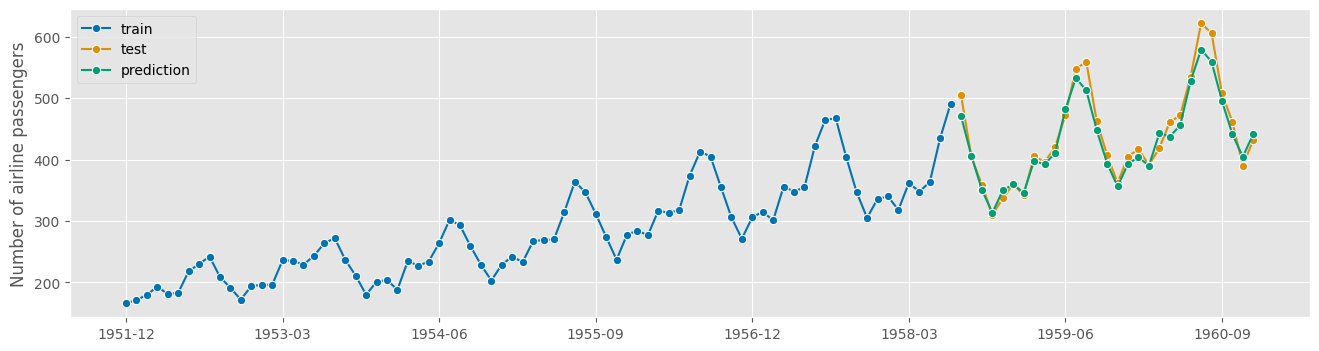

In [139]:
forecaster = AutoETS(error="mul", trend="mul", seasonal="add", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ETS Results                                       
========================================================================================
Dep. Variable:     Number of airline passengers   No. Observations:                  115
Model:                                 ETS(MAN)   Log Likelihood                -523.580
Date:                          Mon, 13 Feb 2023   AIC                           1057.161
Time:                                  20:29:20   BIC                           1070.886
Sample:                              01-31-1949   HQIC                          1062.732
                                   - 07-31-1958   Scale                            0.010
Covariance Type:                         approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.121      8.233      0.000       0.762       1.238
smoothing_trend  9.999e-05        nan        nan        nan         nan         nan
initial_level     106.6029     11.246      9.479      0.000      84.562     128.644
initial_trend       4.2483      1.581      2.687      0.007       1.149       7.347
===================================================================================
Ljung-Box (Q):                        5.34   Jarque-Bera (JB):                 5.35
Prob(Q):                              0.07   Prob(JB):                         0.07
Heteroskedasticity (H):               1.25   Skew:                             0.15
Prob(H) (two-sided):                  0.49   Kurtosis:                         1.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

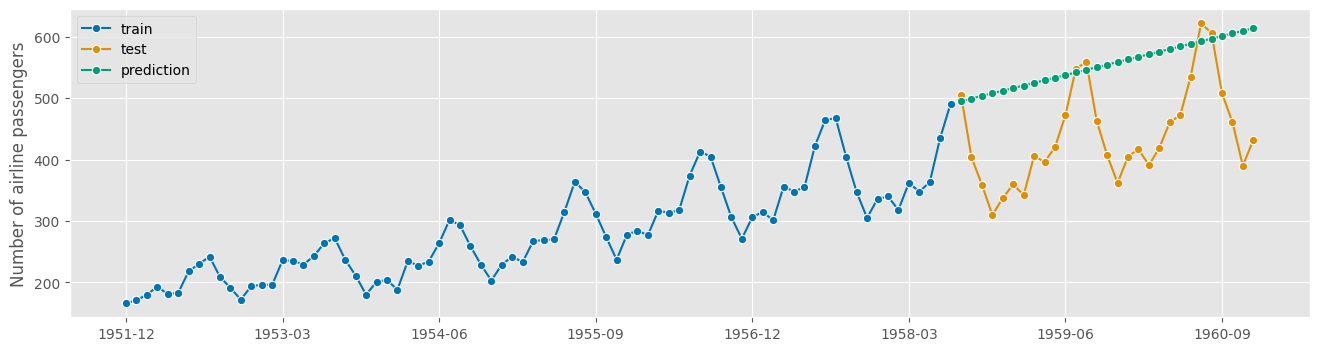

In [140]:
forecaster = AutoETS(auto=True, n_jobs=-1, allow_multiplicative_trend=True )
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')
forecaster.summary()

Поработаем немного с наилучшей моделью

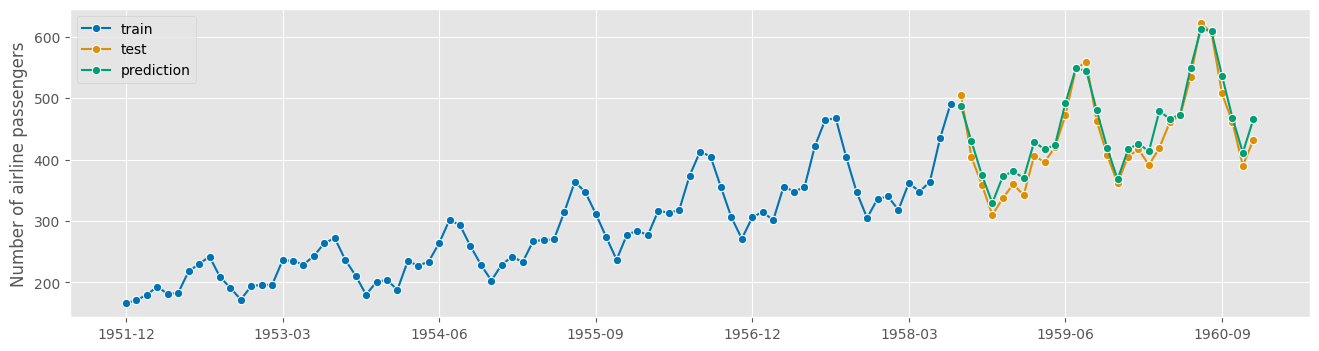

In [141]:
forecaster = AutoETS(error="add", trend="mul", seasonal="mul", sp=12)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=list(range(1,len(y_test)+1)))

plot_series(y_train.tail(80), y_test, y_pred,  labels=['train', 'test', 'prediction']);


print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')

Достанем остатки прогнозов этой модели.

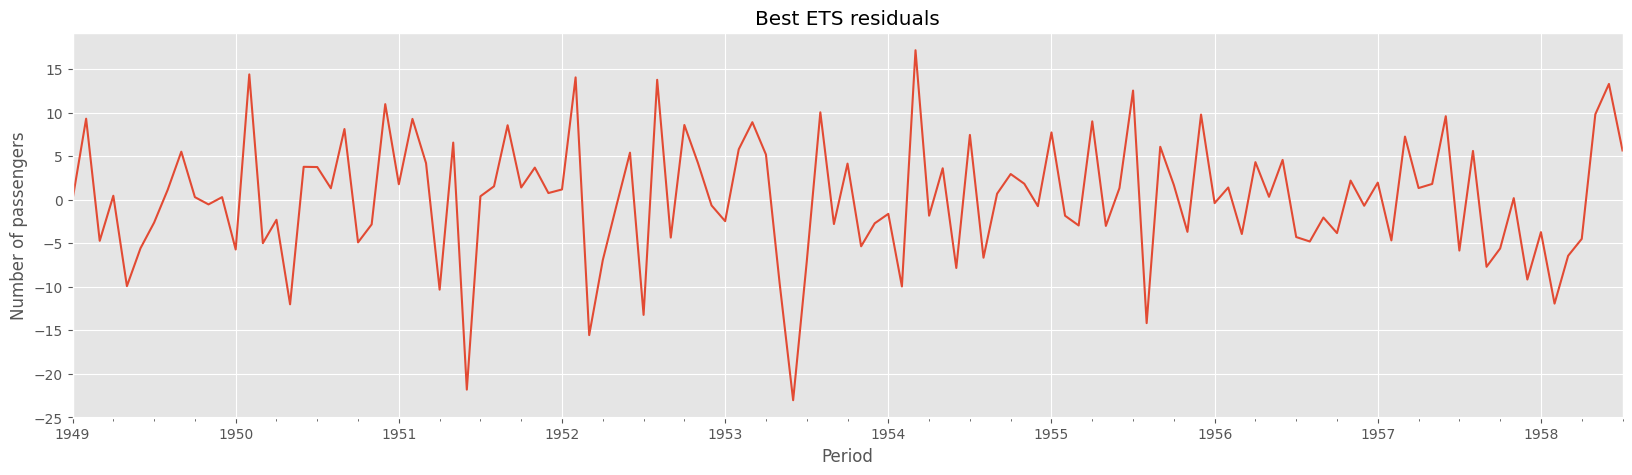

In [142]:
resid = forecaster.predict_residuals()
resid.plot()
plt.title('Best ETS residuals')
plt.ylabel('Number of passengers');

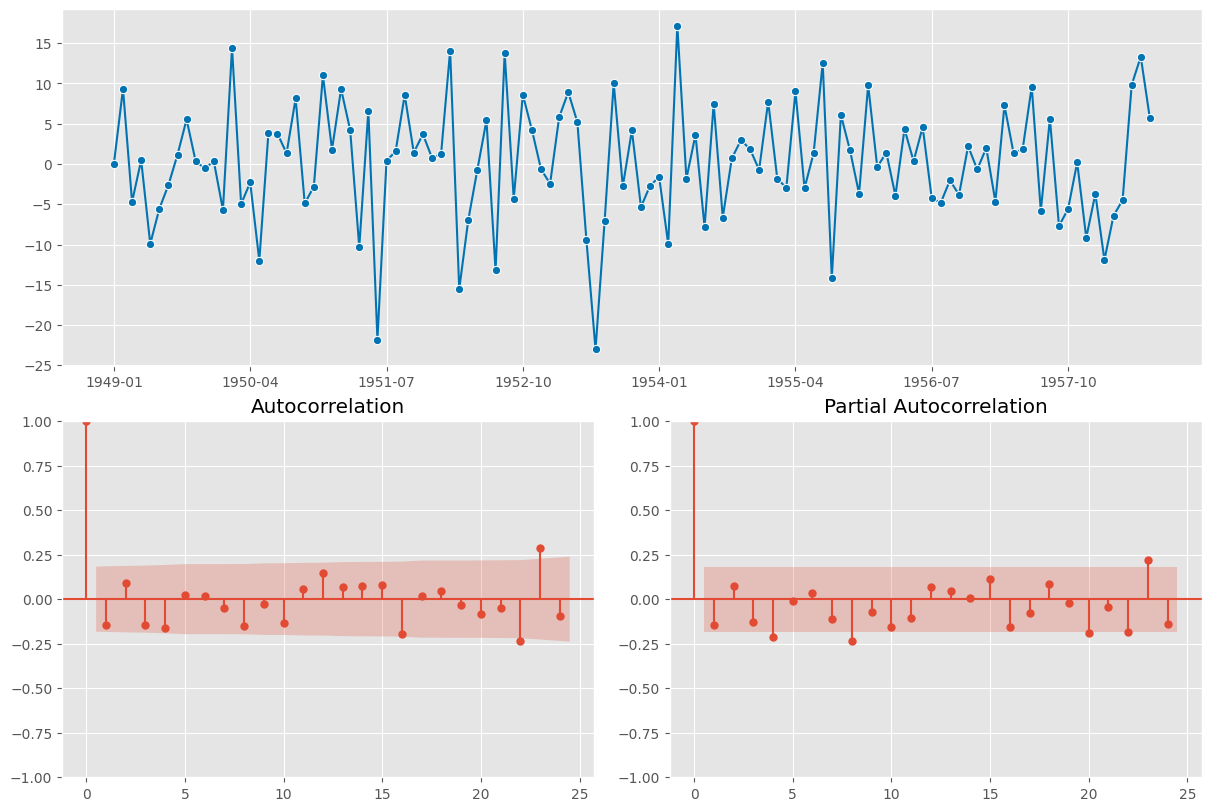

In [143]:
plot_correlations(resid);

Обычно ещё смотрят на величину остатков. Например, на модуль. Но во многих случаях направление ошибки (недооценка или переоценка модели) может иметь большое значение.

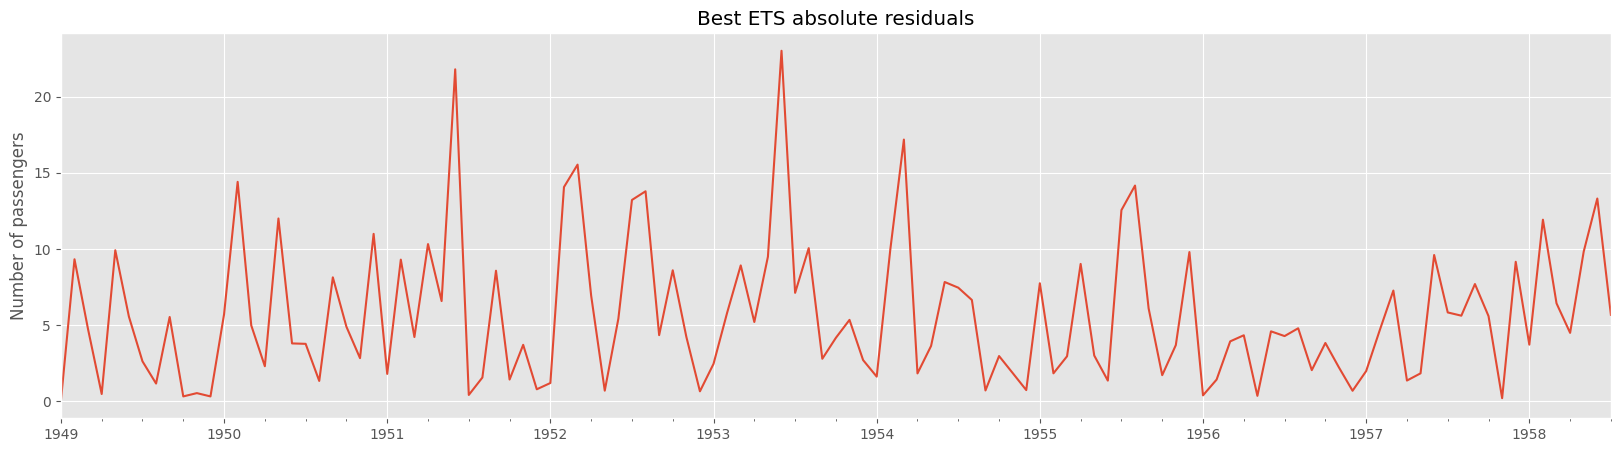

In [144]:
resid.abs().plot()
plt.title('Best ETS absolute residuals')
plt.ylabel('Number of passengers');

Теперь можно попытаться поработать с остатками. Для начала их можно протестировать на наличие линейных взаимосвязей, чтобы понять, аппроксимировали ли мы всю линейную динамику ряда нашей моделью или нет. Если в остатках есть линейные взаимосвязи (а мы их измеряем обычно с помощью автокорреляций или статистических тестов), то наша модель недостаточно хороша. Либо необходимо её улучшить, либо можно построить дополнительную модель. Про тестирование остатков мы поговорим чуть дальше и в частности вы будете этим заниматься во втором ДЗ.

### Общий алгоритм

Временные ряды отличаются некоторой спецификой. Основной проблемой при работе с такими данными является наличие утечек. На всех этапах работы с временными рядами обращайте внимание на потенциальные места, провоцирующие утечки. Ниже я собрал в одну схему некоторую последовательность действий, которые обычно следует совершить при работе с временными рядами. Разберём его по шагам.

![algorithm](images/sem_4_algorithm.png)


1) Эксплоративный анализ. Подробно об этом мы уже поговорили на предыдущих семинарах и сейчас останавливаться не будем. Основная идея: необходимо заметить как можно больше паттернов в ряде, чтобы проще было подбирать модель или фичи.

2) Разбиение на трейн и тест. Эту часть мы с вами также довольно подробно разобрали. Важные особенности, которые следует держать в голове:

* Тест идёт строго после трейна, иначе будет утечка. 
* Если нормируете или как-либо ещё предобрабатываете данные, делайте это только на трейне. Иначе за счёт информации о тесте в нормировке произойдёт утечка.


3) Помимо привычной вам предобработки из машинного обучения, во временных рядах также часто используются преобразования, сводящие ряд к стационарному. Стационарные ряды нам интересны по вполне очевидной причине: чем меньше меняются характеристики ряда по времени, тем проще его прогнозировать. В контексте ETS-моделей этот вопрос не сильно важен. ETS-модели сами по себе моделируют нестационарные ряды с трендами. Однако в контексте ARMA-моделей это будет ключевым вопросом.

* Сделать ряд стационарным по матожиданию можно всегда. Для этого необходимо просто несколько раз последовательно взять разности от него. Количество раз, необходимых для тренд-стационарности ряда, называется порядком интеграции (Integration order) и обычно обозначается как I(k), где k -- порядок интеграции. Про тестирование ряда на стационарность также поговорим через пару семинаров.

* Со стационарностью по дисперсии всё сложнее. Она бывает сложной формы и не всегда можно подобрать такое преобразование, которое её сгладит. В большинстве случаев это просто игнорируют, либо учитывают уже в самой модели (например, мультипликативная сезонность)

Ниже приведён пример обработки ряда с авиаперевозками. Мы видим, что дисперсия зависит от экспоненциального тренда. Попробуем сгладить её логарифмом.

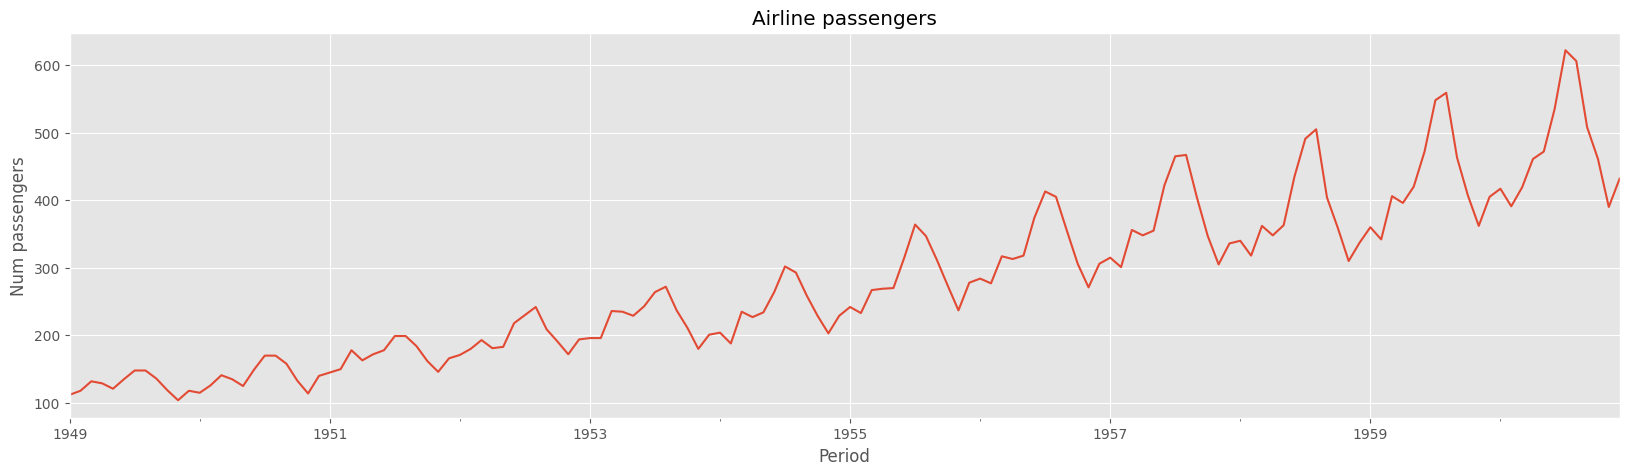

In [66]:


y = load_airline()
y.plot()

plt.title('Airline passengers')
plt.ylabel('Num passengers');


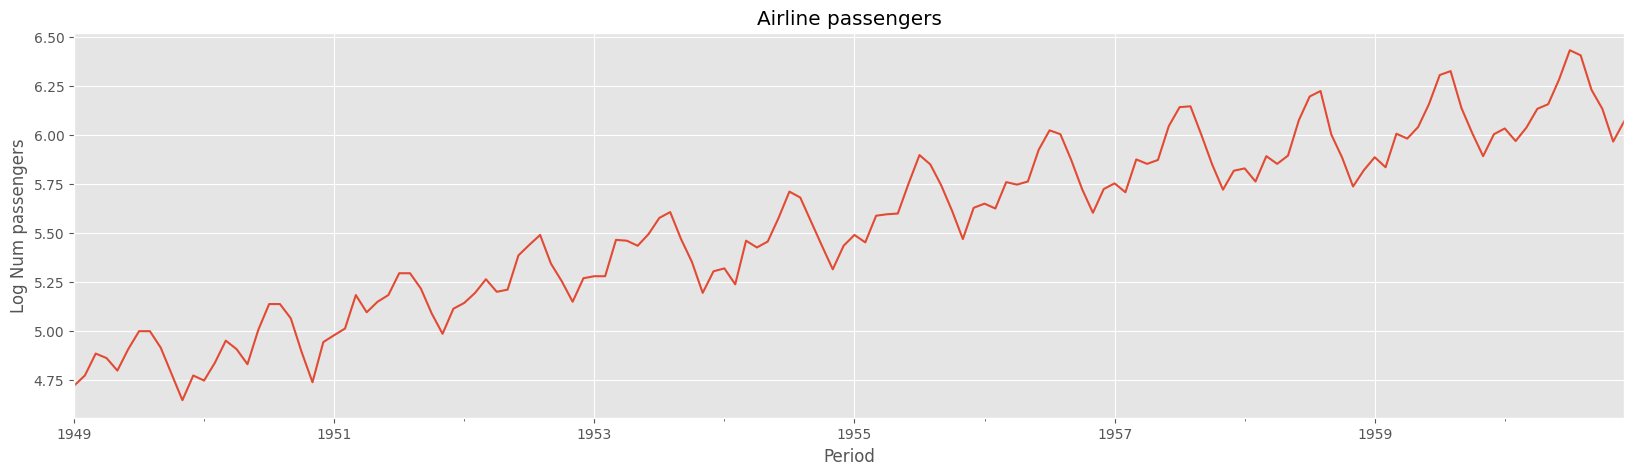

In [67]:

np.log(y).plot()

plt.title('Airline passengers')
plt.ylabel('Log Num passengers');

Преобразование Бокса-Кокса является способом автоматизировать стабилизацию дисперсии. Оно устроено следующим образом:

 $$\frac{y^{\lambda}-1}{\lambda}, \lambda \neq 0 \text { or } \ln (y), \lambda=0$$

Легко показать, что в пределе по $\lambda$ дробь стремится к логарифму. С помощью метода максимального правдоподобия можно найти оценку оптимального параметра  $\lambda$.

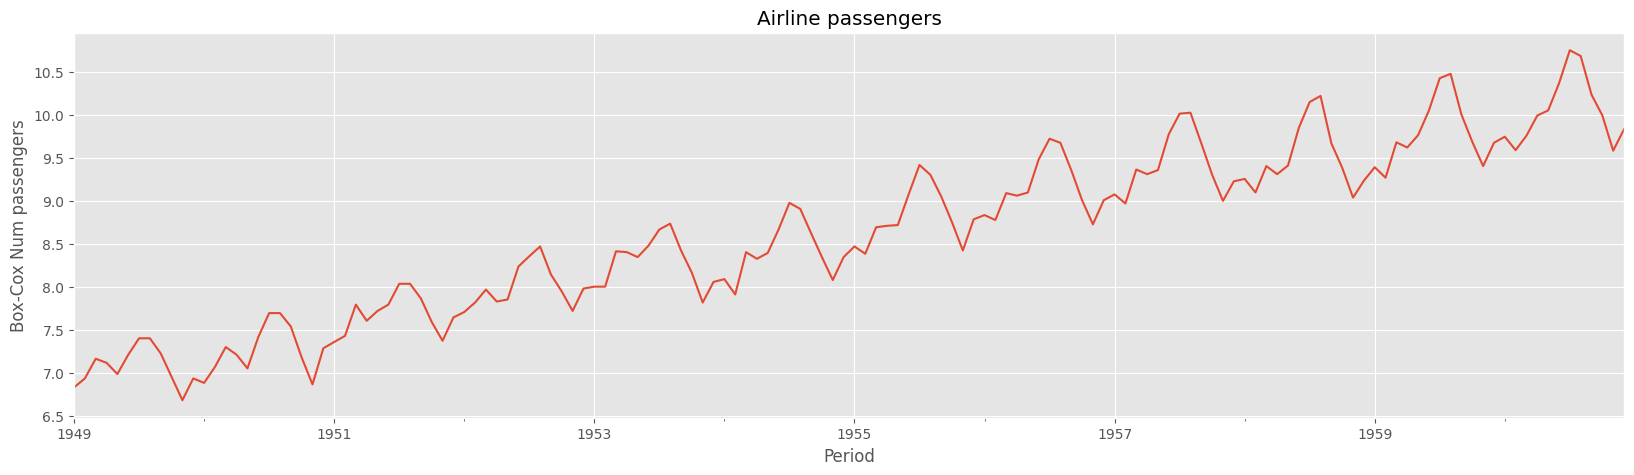

In [68]:
from sktime.transformations.series.boxcox import BoxCoxTransformer

transformer = BoxCoxTransformer()
y_hat = transformer.fit_transform(y)

y_hat.plot()

plt.title('Airline passengers')
plt.ylabel('Box-Cox Num passengers');


In [69]:
transformer.lambda_

0.14802265137037945

Давайте далее возьмём какие-нибудь данные и будем на них сразу практиковаться. У нас будут довольно простые данные, количество игроков в час в одной мобильной онлайн-игре. В наших данных нет особых трендов и монотонных нестационарностей по дисперсии, поэтому преобразовывать ничего не будем. Единственное, что сделаем -- подвинем трейн немного вверх, чтобы мультипликативные модели не сбоили. Далее просто разобьём на трейн и тест.


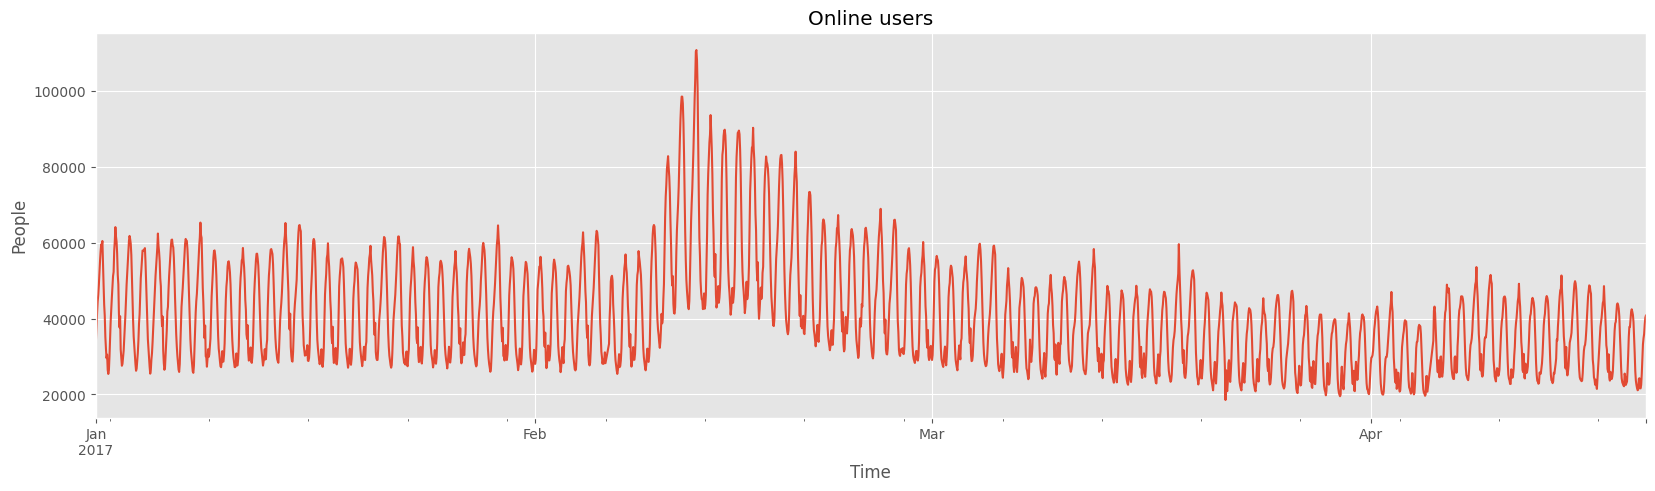

In [148]:
y = pd.read_csv('./data/sem_4/hour_online.csv', index_col=['Time'], parse_dates=['Time']).Users

# Вот этот шаг был неочевиден. С обычным datetime индексом всё ломалось по очевидной недоделке. Думаю, это скоро допилят
y.index = pd.PeriodIndex(y.index, freq="H")
y = y.astype(np.float64)

# Убираем выбросы и интерполируем
y[y<10000] = np.nan
y = y.interpolate()

y_train, y_test = temporal_train_test_split(y, test_size=24)

# y.diff().dropna().plot()
y.plot()
plt.title('Online users')
plt.ylabel('People');

In [105]:
# y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=24)

4) Окей. Мы имеем предобработанные трейн и набор инструкций, чтобы сделать обратные преобразования над прогнозами. Собственно, пора переходить к построению модели. Необходимо выбрать подходящую архитектуру и подобрать на ней гиперпараметры для наилучшего качества прогнозов. Существует ряд автоматических алгоритмов для подбора гиперпараметров. Например, AutoETS и AutoARIMA. Однако большинство из них (за исключением AutoARIMA) представляют из себя обычную кросс-валидацию, зашитую в удобный (или нет) пайплайн.

    На практике обычно руками подобрать модель может быть более эффективно. Например, AutoARIMA я обычно переигрываю при построении на глаз. Поэтому полагаться на них особо не стоит и лучше самостоятельно провести кросс-валидацию. 





5) Допустим вы выбрали самостоятельно делать кросс-валидацию. Для начала следует, полагаясь на здравый смысл и статистические тесты (будет позже), выбрать модели-кандидаты. То есть, построить сетку для кросс-валидации. Посмотрим на данные. Явных трендов почти нет. Значит ограничимся моделями без тренда или с аддитивным трендом. Далее, в районе февраля видим повышение онлайна. Можно заметить, что сезонные колебания в это время были выше. Значит, можно попробовать модели с мультипликативной сезонностью и мультипликативной ошибкой.




In [106]:

from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(list(range(1, len(y_test)+1)))

forecaster = AutoETS(sp=24)
param_grid = {
    'error': ['add', 'mul'],
    'trend': [None, 'add'],
    'seasonal': ['mul'],
#     'damped_trend': [True, False]
}

6) Наша сетка готова. Но про саму кросс-валидацию мы ещё не говорили. А она имеет свои особенности. Во временных рядах нельзя шаффлить (есть аргументы, что можно, но здесь я ретроград) и нельзя ставить трейн после теста хронологически. Значит, учтём эти ограничения. Всего выделяют два основных метода: расширяющегося окна (Expanding window) и скользящего окна (Sliding window). Вообще их больше, но эти два наиболее часто используются. Об остальных можно почитать, например, в [статье](https://arxiv.org/pdf/1905.11744.pdf).

### Метод скользящего окна

Может быть полезен, если данные сильно нестационарны. Поможет не смещать сильно модель относительно далёких данных

![](images/sem_4_crossval_1.jpg)


### Метод расширяющегося окна

Учитывает максимум данных и будет полезен, когда данные более-менее стационарны

![](images/sem_4_crossval_2.jpg)

### Общая картинка

![](images/sem_4_crossval_3.png)

In [109]:
cv = ExpandingWindowSplitter(
    initial_window=700,
    step_length=100,
    # start_with_window=True,
    fh=fh)
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    n_jobs=-1
    )
gscv.fit(y_train);

In [110]:
gscv.best_params_

{'error': 'mul', 'seasonal': 'mul', 'trend': None}

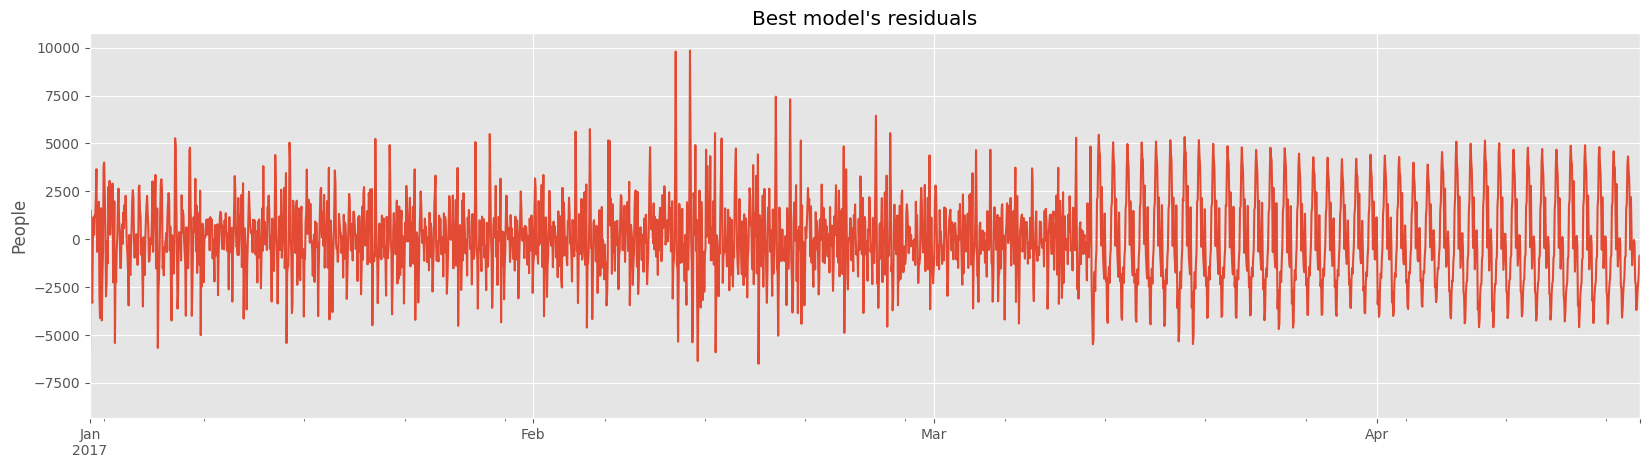

In [146]:
resid = gscv.predict_residuals()

resid.plot()
plt.title('Best model\'s residuals')
plt.ylabel('People');

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

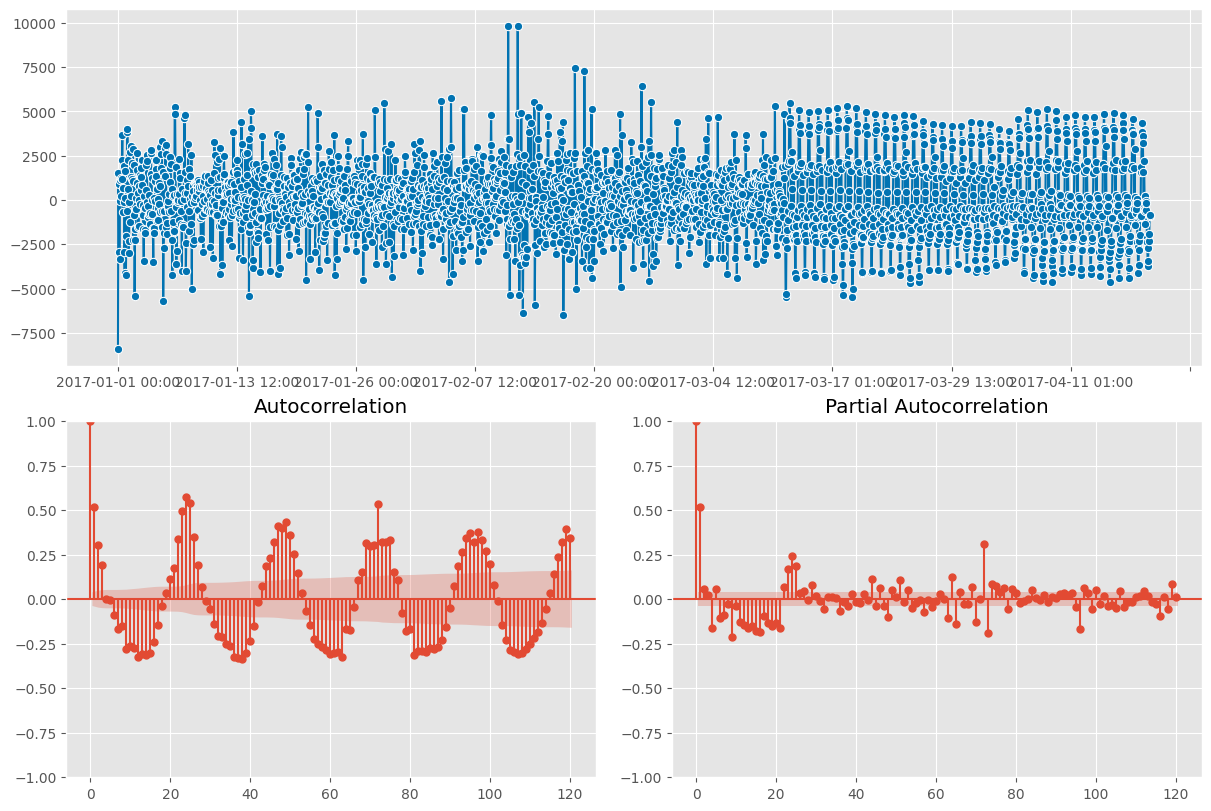

In [147]:
plot_correlations(resid, lags = 24*5)

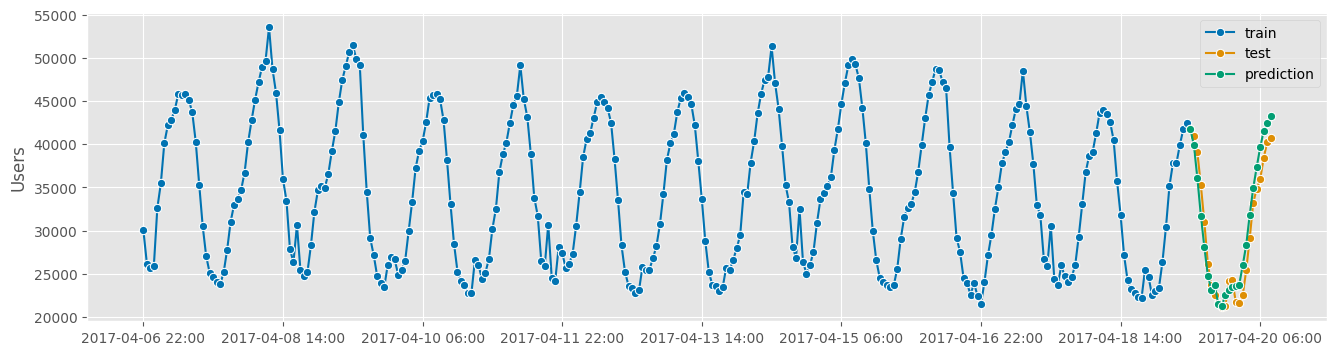

In [113]:
y_pred = gscv.predict(fh)
plot_series(y_train.tail(300), y_test, y_pred,  labels=['train', 'test', 'prediction']);

print(f'Forecast error: {mean_absolute_percentage_error(y_test, y_pred)}')